In [24]:
import numpy as np
import cv2
from scipy.ndimage.filters import convolve
from tqdm import trange
import numba

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

from  matplotlib import pyplot as plt
%matplotlib inline

### RESIZING IMAGE USING CV2 RESIZE FUNCTION

In [76]:
def resizeImage(img, rowScale, colScale):
    resizedImg = cv2.resize(img, (int(img.shape[1]*rowScale), int(img.shape[0]*colScale)),  
               interpolation = cv2.INTER_NEAREST) 
    print(img.shape)
    print(resizedImg.shape)
    return resizedImg

In [59]:
def calc_energy(img):
    filter_dx = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # converting a 2D filter to a 3D filter by replicating the same
    # filter for each channel: R, G, B
    filter_dx = np.stack([filter_dx] * 3, axis=2)

    filter_dy = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # converting a 2D filter to a 3D filter by replicating the same
    # filter for each channel: R, G, B
    filter_dy = np.stack([filter_dy] * 3, axis=2)

    #img = img.astype('float32')
    convolved = np.absolute(convolve(img.astype('float32'), filter_dx)) + np.absolute(convolve(img.astype('float32'), filter_dy))

    # sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

In [60]:
@numba.jit
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [61]:
@numba.jit
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img

In [62]:
def crop_c(img, scale_c):
    print('Applying seam carving columnwise')
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c): # use range if you don't want to use tqdm
        img = carve_column(img)

    return img

In [63]:
def crop_r(img, scale_r):
    print('Applying seam carving rowwise')
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

In [64]:
def SeamCarving(img, rowScale, columnScale):
    temp = crop_r(img, rowScale)
    out = crop_c(temp, columnScale)
    return out

In [91]:
def main():
    inputFile = "tower.jpg"
    img = cv2.imread(inputFile)
    print(img.shape)
    colScale = float(input("Enter col scale "))
    rowScale = float(input("Enter row scale "))
    resizedFileName = inputFile.split('.')[0]+'_resized.jpg'
    seamCarvedFileName = inputFile.split('.')[0]+'_seamCarved.jpg'
    print("Resized file will be saved as: ", resizedFileName)
    print("Seam carved file will be saved as: ", seamCarvedFileName)
    resized = resizeImage(img, rowScale, colScale)
    cv2.imwrite(resizedFileName, resized)
    seamed = SeamCarving(img, colScale, rowScale)
    cv2.imwrite(seamCarvedFileName, seamed)
    return img, resized, seamed

In [92]:
if __name__ == '__main__':
    img, resized, seamed = main()

(186, 274, 3)
Enter col scale 0.9
Enter row scale 0.5


 26%|██▋       | 5/19 [00:00<00:00, 44.20it/s]

Resized file will be saved as:  tower_resized.jpg
Seam carved file will be saved as:  tower_seamCarved.jpg
(186, 274, 3)
(167, 137, 3)
Applying seam carving rowwise
Applying seam carving columnwise


  4%|▍         | 6/137 [00:00<00:02, 54.62it/s]

Applying seam carving columnwise


100%|██████████| 137/137 [00:01<00:00, 69.83it/s]


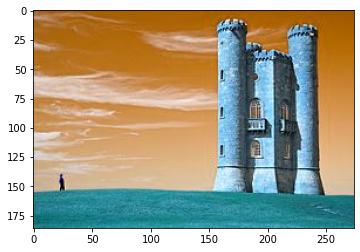

In [93]:
plt.imshow(img)
plt.show()

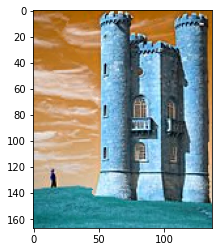

In [94]:
plt.imshow(seamed)
plt.show()

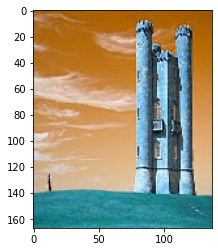

In [95]:
plt.imshow(resized)
plt.show()